In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import json
import matplotlib.dates as mdates
import warnings
# Filter out specific ValueWarnings from statsmodels
warnings.filterwarnings("ignore")

In [2]:
# importing datasets
client = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\client.csv")
hist_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\historical_weather.csv")
train = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\train.csv")
forecast_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\forecast_weather.csv")
electricity = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\electricity_prices.csv")
gas = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\gas_prices.csv")
locations=pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\county_lon_lats.csv")
dict_df = {'train':train, 'client':client, 'gas':gas, 
           'electricity': electricity, 
           'historical_weather':hist_weather, 'forecast_weather':forecast_weather}

In [3]:
# Specify the path to your JSON file
json_file_path = r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\county_id_to_name_map.json"

# Open the JSON file and load its contents
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)


In [4]:
# Display information about features

print("Train Data:")
print(train.info())

print("\nGas Prices Data:")
print(gas.info())

print("\nClient Data:")
print(client.info())

print("\nElectricity Prices Data:")
print(electricity.info())

print("\nForecast Weather Data:")
print(forecast_weather .info())

print("\nHistorical Weather Data:")
print(hist_weather.info())

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None

Gas Prices Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_

These insights provide an overview of the dataset sizes, column names, data types, which can be helpful for further analysis and preprocessing.

In [5]:
# Display shape and column names for all datasets
for df in dict_df.keys():
    print(df)
    print("shape:", dict_df[df].shape)
    print("columns: ", [col for col in dict_df[df].columns])
    print("")

train
shape: (2018352, 9)
columns:  ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id']

client
shape: (41919, 7)
columns:  ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date', 'data_block_id']

gas
shape: (637, 5)
columns:  ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'origin_date', 'data_block_id']

electricity
shape: (15286, 4)
columns:  ['forecast_date', 'euros_per_mwh', 'origin_date', 'data_block_id']

historical_weather
shape: (1710800, 18)
columns:  ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'latitude', 'longitude', 'data_block_id']

forecast_weather
shape: (3424512, 18)
columns:  ['latitude', 'longitude', 'origin_datetime', 'hours_

train

* **county** - An ID code for the county.
* **is_business** - Boolean for whether or not the prosumer is a business.
* **product_type** - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
* **target** - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
* **is_consumption** - Boolean for whether or not this row's target is consumption or production.
* **datetime** - The Estonian time in EET (UTC+2) / EEST (UTC+3).
* **data_block_id** - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
* **row_id** - A unique identifier for the row.
* **prediction_unit_id** - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

In [6]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


Prosumer Distribution by County

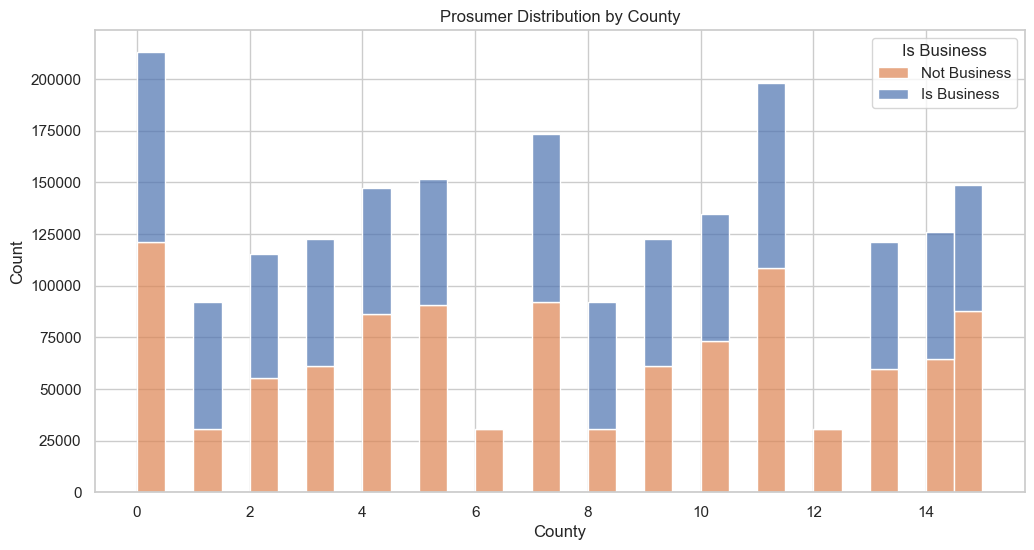

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='county', hue='is_business', multiple='stack', bins=30, alpha=0.7)
plt.xlabel('County')
plt.ylabel('Count')
plt.title('Prosumer Distribution by County')
legend_labels = ['Not Business', 'Is Business']
plt.legend(legend_labels,title='Is Business', loc='upper right')
plt.show()

Overall:

* Non-business prosumers seem to dominate the landscape, but there are pockets of business prosumers in specific counties.
* Factors such as economic activity, renewable energy incentives, and infrastructure play a role in shaping this distribution.

In [8]:
train['datetime'] = pd.to_datetime(train['datetime'])
train_consumption = train[train["is_consumption"]==1]
monthly_consumption = train_consumption.groupby(pd.Grouper(key="datetime", freq='M')).mean()
weekly_consumption = train_consumption.groupby(pd.Grouper(key="datetime", freq='W')).mean()
daily_consumption = train_consumption.groupby(pd.Grouper(key="datetime", freq='D')).mean()
mean_consumption = train_consumption.target.mean()
train_production = train[train["is_consumption"]==0]
monthly_production = train_production.groupby(pd.Grouper(key="datetime", freq='M')).mean()
weekly_production = train_production.groupby(pd.Grouper(key="datetime", freq='W')).mean()
daily_production = train_production.groupby(pd.Grouper(key="datetime", freq='D')).mean()
mean_production = train_production.target.mean()

These steps help in organizing and aggregating the data, making it easier to analyze and visualize patterns in consumption and production over different time intervals. The mean values can give insights into the average consumption and production levels.

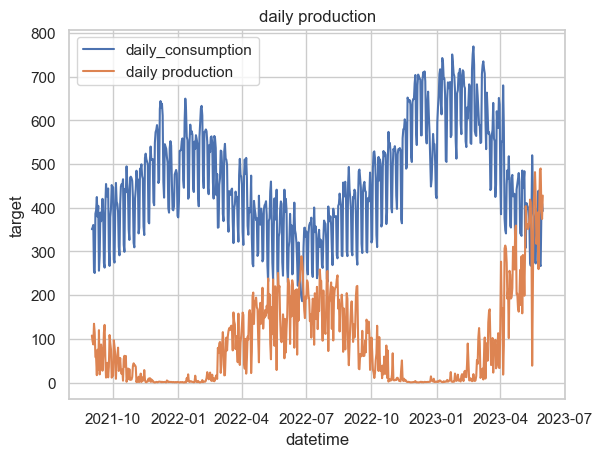

In [9]:
title = 'daily_consumption'
title1 = 'daily production'
sns.lineplot(data = daily_consumption, x = 'datetime', y = 'target',label=title).set(title = title)
sns.lineplot(data = daily_production, x = 'datetime', y = 'target',label=title1).set(title = title1)
plt.legend()
plt.show()

1. The plot shows the daily production and consumption over a period from October 2021 to July 2023. The blue line represents daily consumption, which fluctuates but generally increases over time. The orange line represents daily production, which also fluctuates and follows a similar trend as consumption but is consistently lower.
2. 
- This is a line graph titled "daily production".
- Two lines are plotted: one in blue labeled "daily_consumption" and another in orange labeled "daily production".
- The x-axis is labeled "datetime" and shows a time span from October 2021 to July 2023.
- The y-axis is labeled "target" with values ranging from 0 to 800.
- Both lines show fluctuations over the given time period.
- Daily consumption generally remains higher than daily production throughout the displayed timeframe.



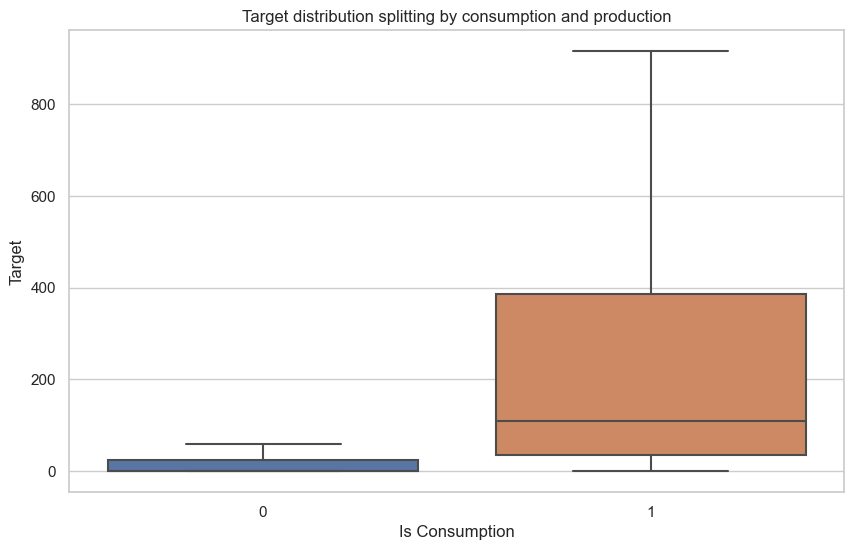

In [10]:
# Set the style
sns.set(style="whitegrid")

# Define the title
title = 'Target distribution splitting by consumption and production'

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='is_consumption', y='target', showfliers=False)

# Set labels and title
plt.xlabel('Is Consumption')
plt.ylabel('Target')
plt.title(title)

# Show the plot
plt.show()

Above graph shows that consumption is much higher than production.

***Client***
* **product_type**
* **county** - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
* **eic_count** - The aggregated number of consumption points (EICs - European Identifier Code).
* **installed_capacity** - Installed photovoltaic solar panel capacity in kilowatts.
* **is_business** - Boolean for whether or not the prosumer is a business.
* **date**
* **data_block_id**

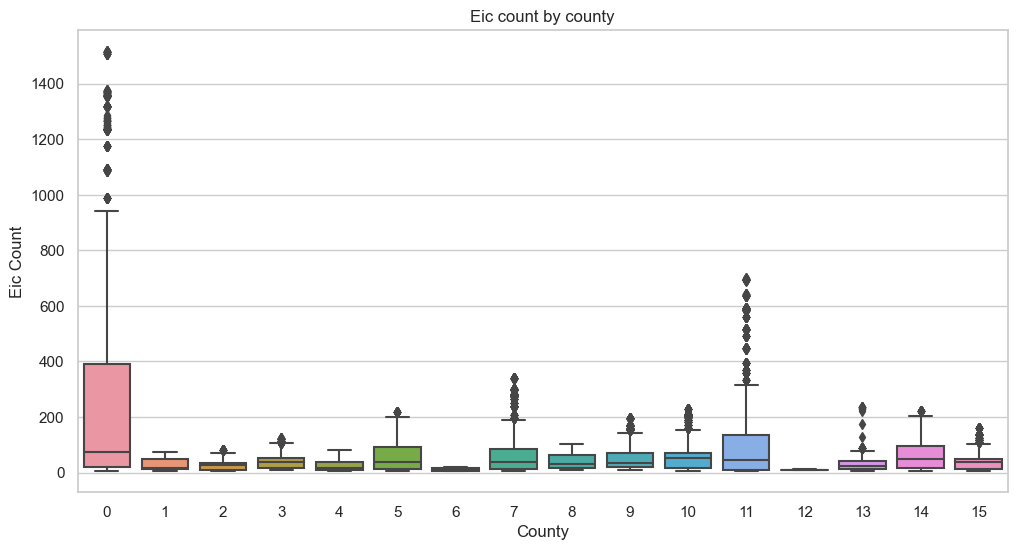

In [11]:
# Set the style
sns.set(style="whitegrid")

# Define the title
title = 'Eic count by county'

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=client, x='county', y='eic_count')

# Set labels and title
plt.xlabel('County')
plt.ylabel('Eic Count')
plt.title(title)

# Show the plot
plt.show()


Notice the correlation between the Eic count and the consumption plotted before
counties `0, 7, 11` have high consumption but also high Eic count!

***gas***
* **origin_date** - The date when the day-ahead prices became available.
* **forecast_date** - The date when the forecast prices should be relevant.
* **[lowest/highest]_price_per_mwh** - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
* **data_block_id**

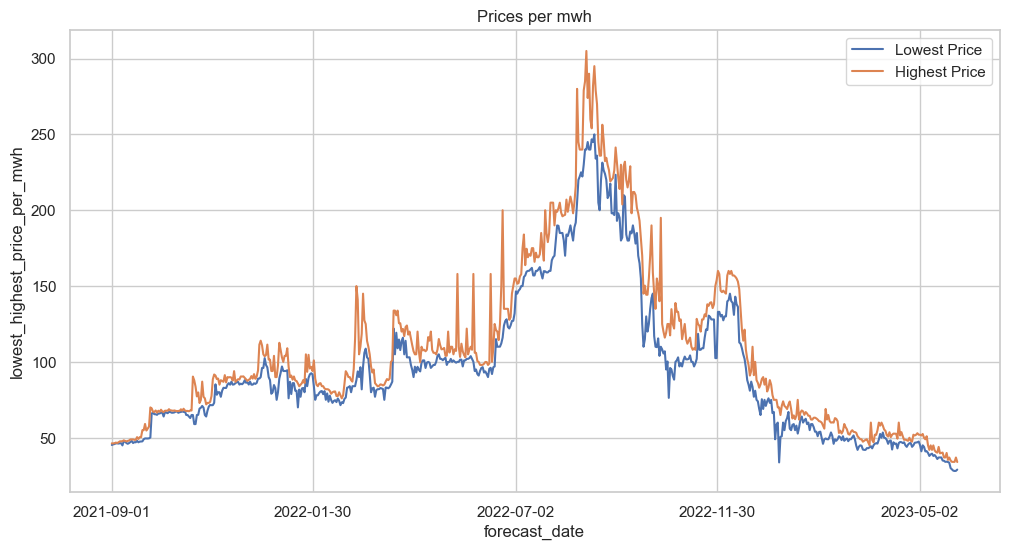

In [12]:
# Set the style
sns.set(style="whitegrid")

# Define the title
title = 'Prices per mwh'

# Create a lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=gas, x='forecast_date', y='lowest_price_per_mwh', label='Lowest Price')
sns.lineplot(data=gas, x='forecast_date', y='highest_price_per_mwh', label='Highest Price')

# Customize x-axis ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))

# Set labels and title
ax.set(title=title, ylabel='lowest_highest_price_per_mwh')
plt.legend()

# Show the plot
plt.show()


***electricity***

* **origin_date**
* **forecast_date** - Represents the start of the 1-hour period when the price is valid
* **euros_per_mwh** - The price of electricity on the day ahead markets in euros per megawatt hour.
* **data_block_id**

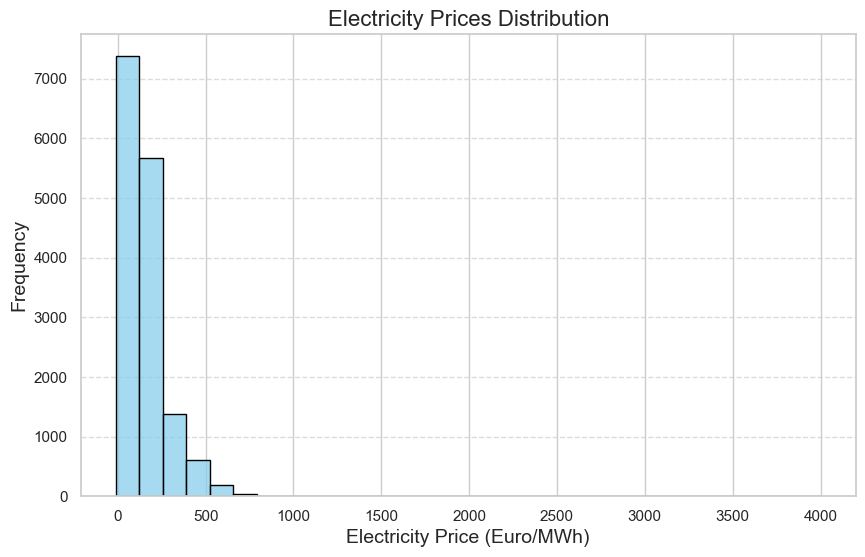

In [13]:
# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(electricity['euros_per_mwh'], bins=30, kde=False, color='skyblue', edgecolor='black')

# Set title and labels
plt.title('Electricity Prices Distribution', fontsize=16)
plt.xlabel('Electricity Price (Euro/MWh)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


1. This plot shows the distribution of electricity prices. The x-axis represents the electricity price in Euro per MWh, and the y-axis represents the frequency of each price range. Most of the prices are concentrated between 0 to 500 Euro/MWh, with a very high frequency reaching up to 7000. The frequency decreases sharply as the price increases.

2. 
- The image is a bar graph titled "Electricity Prices Distribution."
- The x-axis is labeled "Electricity Price (Euro/MWh)" and ranges from 0 to 4000.
- The y-axis is labeled "Frequency" and ranges from 0 to 7000.
- There are five bars in total, with different heights indicating their frequencies.
- The first bar, representing prices from 0 to around 250 Euro/MWh, has the highest frequency reaching up to approximately 7000.
- Frequencies decrease sharply for higher price ranges; for instance, prices between around 250 and 500 Euro/MWh have a frequency of about half compared to the first bar.
- Bars representing prices above approximately 1000 Euro/MWh have negligible frequencies.

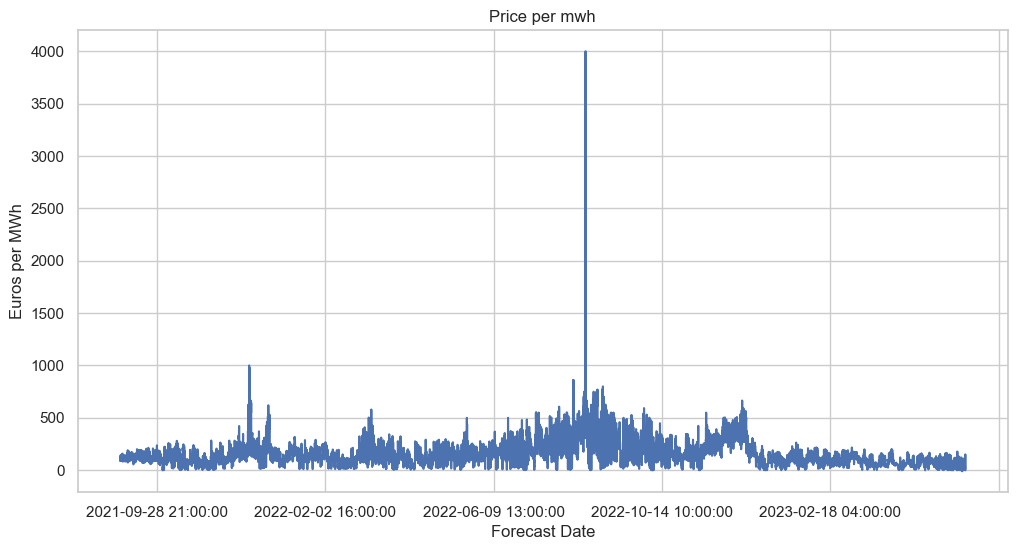

In [14]:
# Set the style
sns.set(style="whitegrid")

# Define the title
title = 'Price per mwh'

# Create a lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=electricity, x='forecast_date', y='euros_per_mwh')

# Customize x-axis ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=100))

# Set labels and title
ax.set(title=title, xlabel='Forecast Date', ylabel='Euros per MWh')

# Show the plot
plt.show()


***forecast_weather***
* **[latitude/longitude]** - The coordinates of the weather forecast.
* **origin_datetime** - The timestamp of when the forecast was generated.
* **hours_ahead** - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
* **temperature** - The air temperature at 2 meters above ground in degrees Celsius.
* **dewpoint** - The dew point temperature at 2 meters above ground in degrees Celsius.
* **cloudcover_[low/mid/high/total]** - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total.
* **10metre[u/v]_wind_component** - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second.
* **data_block_id**
* **forecast_datetime** - The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead.
* **direct_solar_radiation** - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
* **surface_solar_radiation_downwards** - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, in watt-hours per square meter.
* **snowfall** - Snowfall over the previous hour in units of meters of water equivalent.
* **total_precipitation** - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the preceding hour, in units of meters.
---

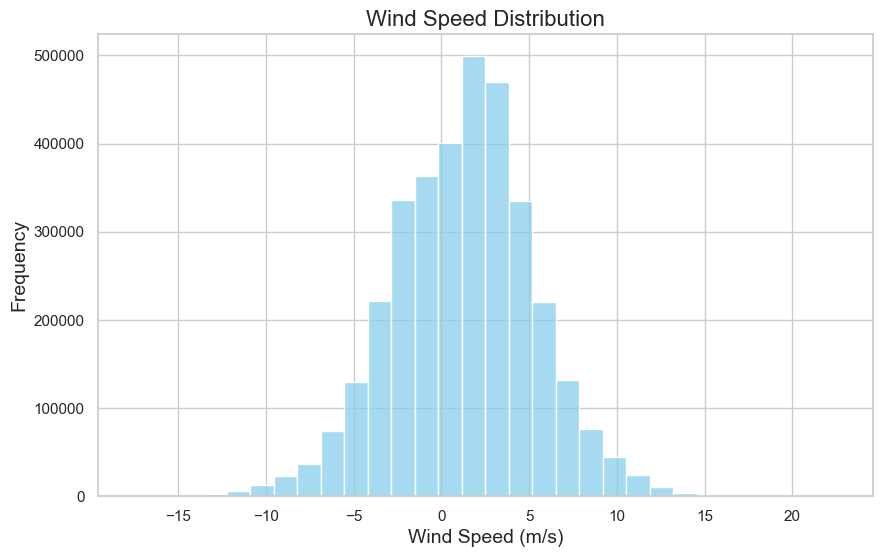

In [17]:
# Set the style
sns.set(style="whitegrid")

# Create a figure with a specified size
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(forecast_weather['10_metre_u_wind_component'], bins=30, kde=False, color='skyblue')

# Set the title and axis labels
plt.title('Wind Speed Distribution', fontsize=16)
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


In summary, calm winds dominate, and extreme wind speeds occur less frequently. This graph provides insights into wind patterns.

***hist_weather***
* **datetime**
* **temperature**
* **dewpoint**
* **rain** - Different from the forecast conventions. The rain from large scale weather systems of the preceding hour in millimeters.
* **snowfall** - Different from the forecast conventions. Snowfall over the preceding hour in centimeters.
* **surface_pressure** - The air pressure at surface in hectopascals.
* **cloudcover_[low/mid/high/total]** - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
* **windspeed_10m** - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
* **winddirection_10m** - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
* **shortwave_radiation** - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
* **direct_solar_radiation**
* **diffuse_radiation** - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
* **[latitude/longitude]** - The coordinates of the weather station.
* **data_block_id**

In [19]:
hist_weather.describe()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
count,1710800,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06
mean,2022-07-16 05:00:00.000001536,5.703857e+00,2.209087e+00,4.949369e-02,1.612128e-02,1.009281e+03,6.102065e+01,4.682182e+01,3.445699e+01,3.608472e+01,4.854635e+00,1.978516e+02,1.059350e+02,6.404775e+01,4.188727e+01,5.865000e+01,2.495000e+01,3.192706e+02
min,2021-09-01 00:00:00,-2.370000e+01,-2.590000e+01,0.000000e+00,0.000000e+00,9.429000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.760000e+01,2.170000e+01,1.000000e+00
25%,2022-02-07 02:00:00,0.000000e+00,-2.700000e+00,0.000000e+00,0.000000e+00,1.001500e+03,2.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.812500e+01,2.320000e+01,1.600000e+02
50%,2022-07-16 05:00:00,5.100000e+00,1.600000e+00,0.000000e+00,0.000000e+00,1.010400e+03,7.200000e+01,4.000000e+01,1.600000e+01,1.000000e+01,4.500000e+00,2.080000e+02,1.000000e+00,0.000000e+00,1.000000e+00,5.865000e+01,2.495000e+01,3.190000e+02
75%,2022-12-22 08:00:00,1.110000e+01,7.200000e+00,0.000000e+00,0.000000e+00,1.018000e+03,1.000000e+02,9.400000e+01,7.200000e+01,8.600000e+01,6.277778e+00,2.630000e+02,1.380000e+02,4.700000e+01,7.400000e+01,5.917500e+01,2.670000e+01,4.780000e+02
max,2023-05-30 10:00:00,3.260000e+01,2.260000e+01,1.680000e+01,2.660000e+00,1.049300e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.175000e+01,3.600000e+02,8.480000e+02,7.390000e+02,3.860000e+02,5.970000e+01,2.820000e+01,6.370000e+02
std,NaN,8.012687e+00,7.211465e+00,2.064676e-01,7.485325e-02,1.309908e+01,3.775467e+01,4.076018e+01,3.835464e+01,4.137401e+01,2.478987e+00,8.992159e+01,1.793882e+02,1.329057e+02,6.184148e+01,6.873866e-01,2.015565e+00,1.837299e+02


`(EDA)` is a foundational step in data analysis, involving the thorough examination and visualization of datasets to comprehend their structure, identify patterns, and extract meaningful insights. Through descriptive statistics, visualizations, and pattern recognition, EDA helps assess data quality, handle missing values, and detect outliers, ensuring a robust foundation for subsequent modeling. EDA not only informs feature engineering and modeling decisions but also supports effective communication of findings to stakeholders. By providing a comprehensive understanding of the data, EDA guides data scientists in making informed decisions throughout the data science workflow and facilitates the extraction of valuable knowledge from complex datasets.